### Siamese Classifier

In [1]:
from Tumor_Classifier_Utils import *
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
# loading in data
train, train_y, val, val_y, test, test_y, N, num_classes = load_data(64)


print(train.shape)
print(val.shape)
print(test.shape)
print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

(2450, 64, 64, 1)
(350, 64, 64, 1)
(283, 64, 64, 1)
(2450, 1)
(350, 1)
(283, 1)


In [3]:
def GetSiameseData(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def PairGenerator(imgs, labels, batch_size):
    while True:
        [image_a, image_b], label = GetSiameseData(imgs, labels, batch_size)
        yield [image_a, image_b], label

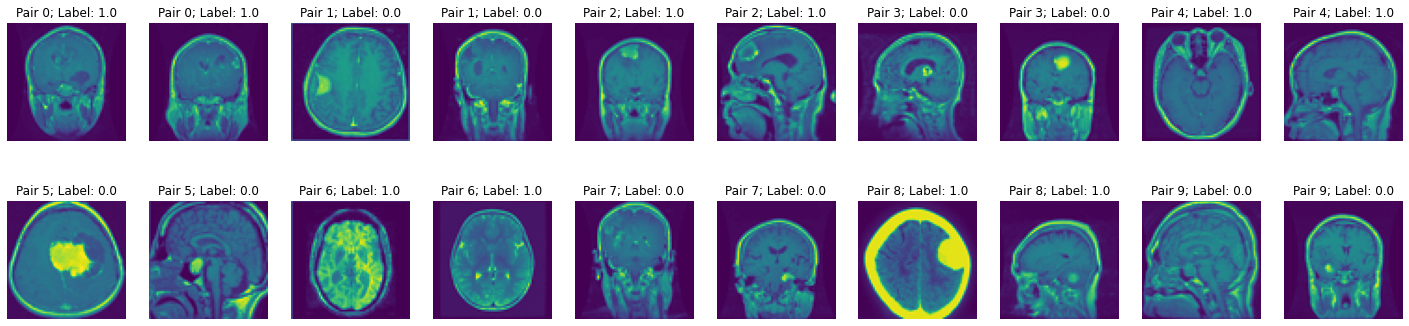

In [4]:
test_gen = PairGenerator(train, train_y, 10)
x, y = next(test_gen)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
    ax.axis('off')
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))  
    ax.axis('off')

## The Network

In [5]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

In [6]:
embedding_size = 32
dummy_input = keras.Input((N, N, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')
base_network.summary()

Model: "SiameseBranch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         584       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 8)         0         
                                                                 
 spatial_dropout2d (SpatialD  (None, 64, 64, 8)        0         
 ropout2D)                                           

In [7]:
input_a = keras.Input((N, N, 1), name='InputA')
input_b = keras.Input((N, N, 1), name='InputB')

embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

In [8]:
combined = layers.concatenate([embedding_a, embedding_b])
combined = layers.Dense(128, activation='relu')(combined)
output = layers.Dense(1, activation='sigmoid')(combined)

siamese_network = keras.Model([input_a, input_b], output, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputA (InputLayer)            [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 InputB (InputLayer)            [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 SiameseBranch (Functional)     (None, 32)           2124920     ['InputA[0][0]',                 
                                                                  'InputB[0][0]']                 
                                                                                                  
 concatenate (Concatenate)      (None, 64)           0           ['SiameseBranch[0][0

In [9]:
keras.utils.plot_model(siamese_network, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [10]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [12]:
siamese_network.compile(loss=loss(margin=1), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [13]:
batch_size = 128
training_gen = PairGenerator(train, train_y, batch_size)

siamese_val_x, siamese_val_y = GetSiameseData(val, val_y, 128)

classWeights = class_weights()
start_train_time = time.time()
history = siamese_network.fit(training_gen, steps_per_epoch = 2000 // batch_size, epochs=100, validation_data = (siamese_val_x, siamese_val_y), class_weight=classWeights)
train_time = time.time() - start_train_time

Epoch 1/100
15/15 [==============================] - 8s 52ms/step - loss: 0.4232 - accuracy: 0.4917 - val_loss: 0.2556 - val_accuracy: 0.5000
Epoch 2/100
15/15 [==============================] - 0s 25ms/step - loss: 0.3882 - accuracy: 0.5240 - val_loss: 0.2503 - val_accuracy: 0.5000
Epoch 3/100
15/15 [==============================] - 0s 25ms/step - loss: 0.3891 - accuracy: 0.5167 - val_loss: 0.2502 - val_accuracy: 0.5000
Epoch 4/100
15/15 [==============================] - 0s 25ms/step - loss: 0.3706 - accuracy: 0.5568 - val_loss: 0.2498 - val_accuracy: 0.5078
Epoch 5/100
15/15 [==============================] - 0s 24ms/step - loss: 0.3519 - accuracy: 0.6099 - val_loss: 0.2530 - val_accuracy: 0.5000
Epoch 6/100
15/15 [==============================] - 0s 24ms/step - loss: 0.3443 - accuracy: 0.6115 - val_loss: 0.2485 - val_accuracy: 0.5625
Epoch 7/100
15/15 [==============================] - 0s 26ms/step - loss: 0.3243 - accuracy: 0.6578 - val_loss: 0.2514 - val_accuracy: 0.5078
Epoch 

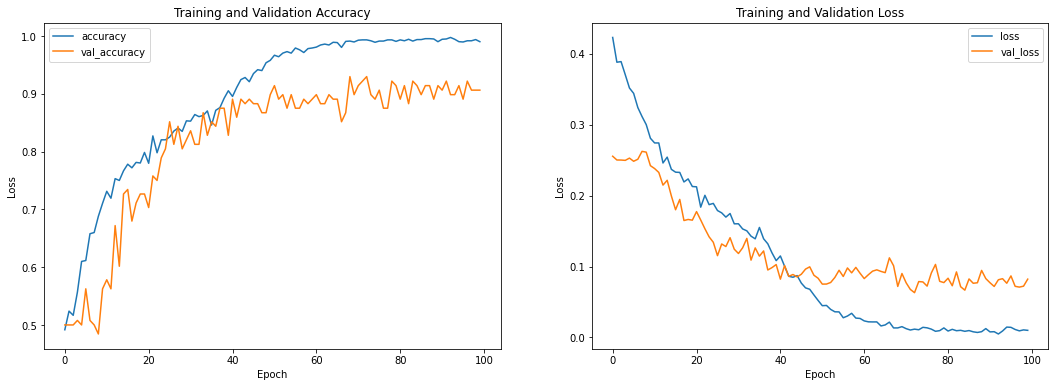

In [14]:
plot_loss(history)

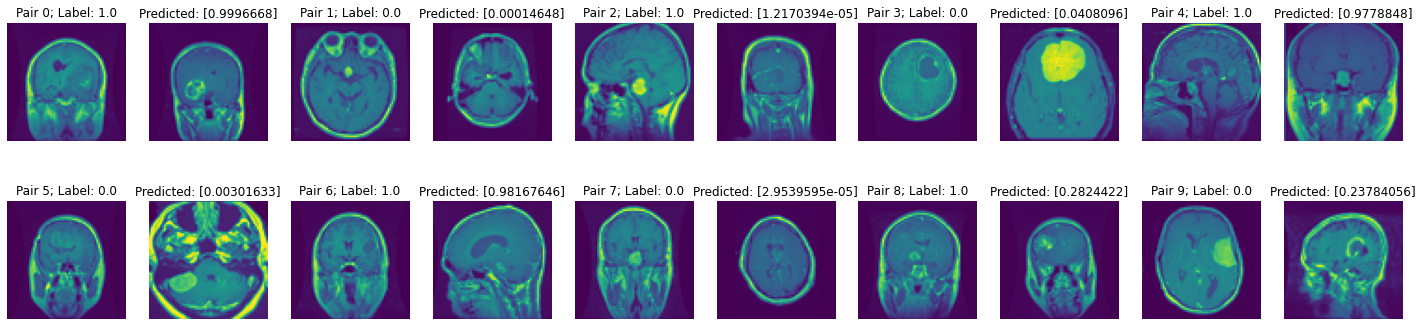

In [15]:
x, y = GetSiameseData(test, test_y, 10)
res = siamese_network.predict(x)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
    ax.axis('off')
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Predicted: ' + str(res[i]))
    ax.axis('off')

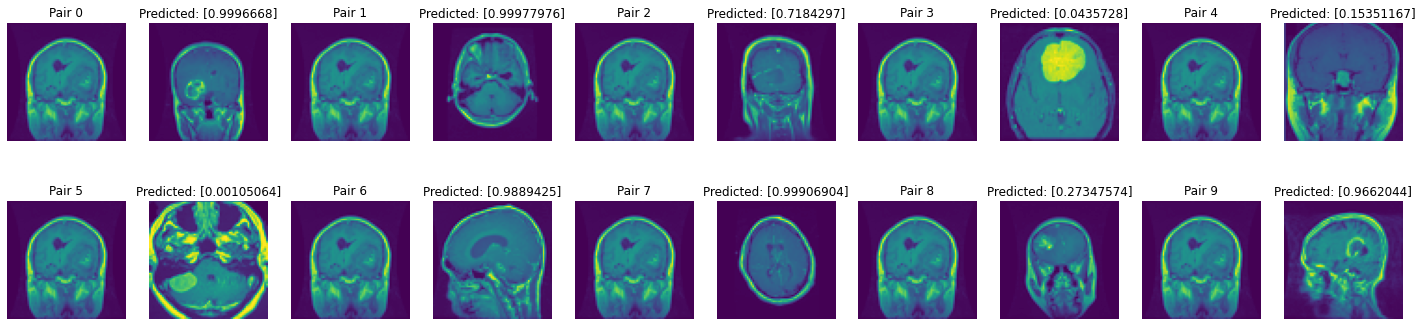

In [16]:
for i in range(10):
    x[0][i,:] = x[0][0,:]

res = siamese_network.predict(x)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i))
    ax.axis('off')
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Predicted: ' + str(res[i]))
    ax.axis('off')

c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


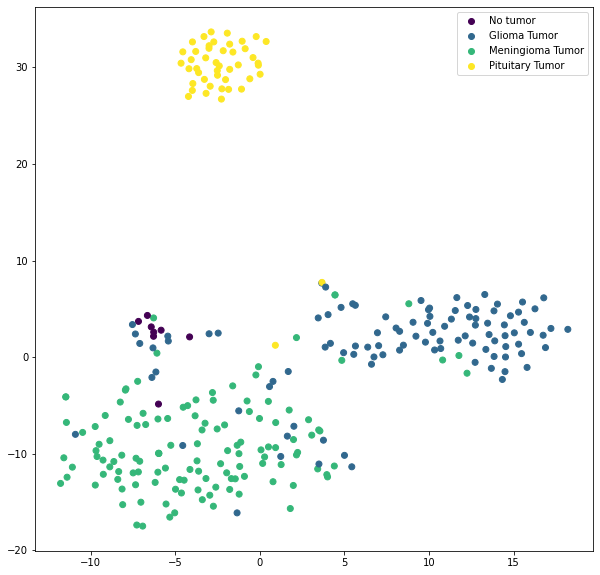

In [17]:
embeddings = base_network.predict(test)
tsne_embeddings = TSNE(n_components=2,random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
labels = ['No tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']
scatter = ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = test_y.flatten());
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
'''
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.view_init(30, 270)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = test_y.flatten());'''
plt.show()

In [18]:
def search_hyperparams(model, params, X_train, Y_train, X_validate, Y_validate):
    # Create list of all possible combinations
    param_list = list(ParameterGrid(params))
    
    # Initialising 
    best_result = 0.00;
    best_params = param_list[0];
    worst_result = 1.00;
    worst_params = param_list[0];
    # looping through all parameters in parameter list
    for params in param_list:
        # creating model with set parameters
        model = model.set_params(**params)
        # training the model
        model.fit(X_train, Y_train)
        # retrieving model score
        result = model.score(X_validate, Y_validate)
        # checking if model score is better, then allocating best parameters
        if result > best_result:
            best_result = result
            best_params = params
        if result < worst_result:
            worst_result = result
            worst_params = params
    
    # Return the best
    print(best_params)
    print("Validation Accuracy " + str(best_result))
    print(worst_params)
    print("Validation Accuracy " + str(worst_result))
    return best_params

In [19]:
embeddings_train = base_network.predict(train)
embeddings_test = base_network.predict(test)
print(embeddings_train.shape)
print(train_y.shape)
print(embeddings_test.shape)
print(test_y.shape)
tsne_embeddings_train = TSNE(n_components=1,random_state=4).fit_transform(embeddings_train)
tsne_embeddings_test = TSNE(n_components=1,random_state=4).fit_transform(embeddings_test)
print(tsne_embeddings_train.shape)

(2450, 32)
(2450, 1)
(283, 32)
(283, 1)


c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2450, 1)


In [20]:
model = SVC()
param_grid = {'class_weight': ['balanced'], 'decision_function_shape': ['ovo', 'ovr'], 'C': list(range(1, 30)), 'gamma': [0.00005, 0.0001, 0.0003, 0.0005], 'kernel' : ['rbf', 'sigmoid']}
best_params = search_hyperparams(model, param_grid, tsne_embeddings_train, train_y, tsne_embeddings_test, test_y)
svm = model.set_params(**best_params)
svm.fit(embeddings_train, train_y)

c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConve

{'C': 1, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 5e-05, 'kernel': 'rbf'}
Validation Accuracy 0.44876325088339225
{'C': 1, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 5e-05, 'kernel': 'rbf'}
Validation Accuracy 0.44876325088339225


c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConve

SVC(C=1, class_weight='balanced', decision_function_shape='ovo', gamma=5e-05)

In [21]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    labels = ['No Tumour', 'Glioma', 'Meningioma', 'Pituitary']
    fig = plt.figure(figsize=[18, 6])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, ax=ax, display_labels=labels)
    ax = fig.add_subplot(1, 2, 2)
    start_inference_time = time.time()
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, ax=ax, display_labels=labels)
    inference_time = time.time() - start_inference_time
    print(classification_report(Y_test, model.predict(X_test)))
    return inference_time

              precision    recall  f1-score   support

           0       0.44      0.88      0.58         8
           1       0.91      0.80      0.85       102
           2       0.90      0.91      0.91       127
           3       0.96      1.00      0.98        46

    accuracy                           0.89       283
   macro avg       0.80      0.90      0.83       283
weighted avg       0.90      0.89      0.89       283



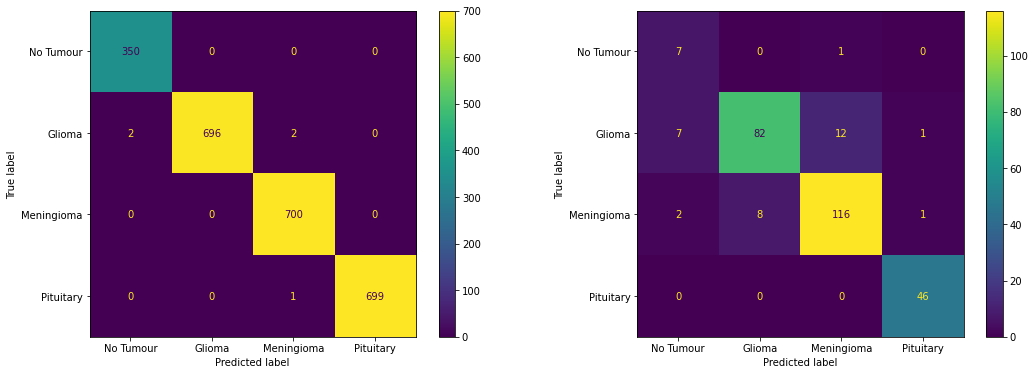

In [22]:
inference_time = eval_model(svm, embeddings_train, train_y, embeddings_test, test_y)

[ 16   8  90 102 129 127  48  46]


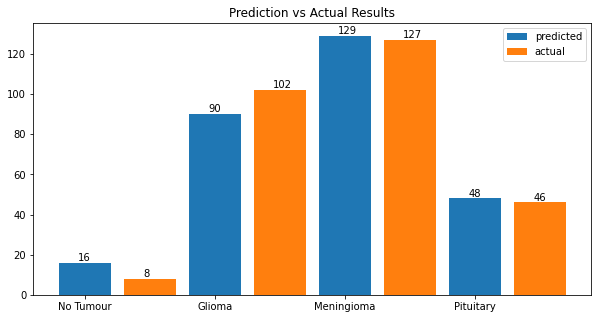

In [23]:
pred = svm.predict(embeddings_test);

fig = plt.figure(figsize=[10, 5])
ax = fig.subplots()

test_thing = test_y[:] + 0.5

all_counts = []
for i in range(len(pred)):
    all_counts.append(pred[i])
    all_counts.append(test_thing[i][0])

labels_all, count_all = np.unique(all_counts, return_counts=True)
print(count_all)

labels, counts = np.unique(pred, return_counts=True)
labels = ['No Tumour', 'Glioma', 'Meningioma', 'Pituitary']
ax.set_title('Prediction vs Actual Results')
plt.bar(labels, counts, align='center', width = 0.4)
plt.gca().set_xticks(labels)
test_thing = test_y[:] + 0.5
labels, counts = np.unique(test_thing, return_counts=True)
plt.bar(labels, counts, align='center', width = 0.4)
ax.legend(['predicted', 'actual'])

x = [0,0.5,1,1.5,2,2.5,3,3.5]

for i in range(len(count_all)):
    ax.text(x[i]-0.05, count_all[i] + 1, str(count_all[i]))
    
plt.show()

In [24]:
print(train_time)
print(inference_time)

44.67946767807007
0.02950143814086914
